# Covid classifiers

In [8]:
import pandas as pd

In [149]:
# Load training and test data
train_data = pd.read_table("data/a3_train_final.tsv", names=["annotation", "comment"])
test_data = pd.read_table("data/a3_test.tsv", names=["annotation", "comment"])

train_data.head()

,annotation,comment
0,1/1,I'll only consume if I know what's inside it....
1,0/-1,It is easier to fool a million people than it...
2,0/0,NATURAL IMMUNITY protected us since evolutio...
3,0/-1,NATURAL IMMUNITY protected us since evolutio...
4,1/1/1/-1,The bigest sideffect of vaccines is fewer dea...


In [150]:
# Preprocess the comments to remove punctuations and convert all the text to lowercase.
import string

train_data['comment'] = train_data['comment'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)))
test_data['comment'] = test_data['comment'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)))


In [152]:
# Split data into X and Y sets and do the preprocessing of annotations
from collections import Counter

# Rules for choosing actual annotation
def most_common_annotation(anno):
    # Divide up all the annotations
    annotations = anno.split("/")

    # If there are more annotations than unique annotations then return -1
    if len(annotations) == len(set(annotations)):
        return '-1'

    # If someone is confused by the sentence then return -1
    if ('-1' in annotations) and len(annotations) == 2:
        return '-1'

    annotation_counter = Counter(annotations)
    most_common = annotation_counter.most_common(2)
    
    # If there's a tie then return -1
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return '-1'

    return most_common[0][0]

# Assign the most common annotation to Ytrain
most_common = train_data["annotation"].apply(most_common_annotation)
train_data["annotation"] = most_common

# Drop rows with a label of -1
train_data.drop(train_data[train_data['annotation'] == "-1"].index, inplace=True)

Xtrain = train_data["comment"]
Ytrain = train_data["annotation"]

# Convert labels to int to match test set
Ytrain = Ytrain.astype('int')

# Assign ytest data
Xtest = test_data["comment"]
Ytest = test_data["annotation"]

In [153]:
# General imports

# Import TfidfVectorizer, CountVectorizer, HashingVectorizer for feature extraction of comments
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

# for bundling the vectorizer and the classifier as a single "package"
from sklearn.pipeline import make_pipeline

# for evaluating the quality of the classifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

In [154]:
# Print Accuracy, Recall, F1 and Precision scores
def print_scores(name, y_true, y_pred):
    acc = round(accuracy_score(y_true, y_pred), 3)
    re = round(recall_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)
    pre = round(precision_score(y_true, y_pred), 3)
    print(f"{name}: Accuracy: {acc}, Recall: {re}, F1: {f1}, Precision: {pre}")

In [155]:
# Baseline classifier
from sklearn.dummy import DummyClassifier

dummy_pipeline = make_pipeline(
    DummyClassifier(strategy='most_frequent')
)
dummy_pipeline.fit(Xtrain, Ytrain)
print_scores("Baseline test scores", Ytest, dummy_pipeline.predict(Xtest))
print("Baseline classifier training cross validation score: ", cross_val_score(dummy_pipeline, Xtrain, Ytrain))

Baseline test scores: Accuracy: 0.5, Recall: 1.0, F1: 0.667, Precision: 0.5
Baseline classifier training cross validation score:  [0.504268   0.504268   0.504268   0.50418814 0.50418814]


In [89]:
# LinearSVC classifier
from sklearn.svm import LinearSVC

# TD-IDF Vectorizer + LinearSVC classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    LinearSVC(max_iter=20_000)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + LinearSVC classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + LinearSVC classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Count Vectorizer + LinearSVC classifier pipeline
pipeline = make_pipeline(
    CountVectorizer(),
    LinearSVC(max_iter=20_000)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Count Vectorizer + LinearSVC classifier test scores", Ytest, pipeline.predict(Xtest))
print("Count Vectorizer + LinearSVC classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Hashing Vectorizer + LinearSVC classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    LinearSVC(max_iter=20_000)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hashing Vectorizer + LinearSVC classifier test scores", Ytest, pipeline.predict(Xtest))
print("Hashing Vectorizer + LinearSVC classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

TF-IDF Vectorizer + LinearSVC classifier test scores: Accuracy: 0.845, Recall: 0.841, F1: 0.845, Precision: 0.848
TF-IDF Vectorizer + LinearSVC classifier training cross validation score:  [0.82350081 0.79529984 0.80988655 0.81504296 0.81844707]
Count Vectorizer + LinearSVC classifier test scores: Accuracy: 0.831, Recall: 0.827, F1: 0.831, Precision: 0.834
Count Vectorizer + LinearSVC classifier training cross validation score:  [0.8082658  0.78055105 0.78865478 0.79494245 0.79980548]
Hashing Vectorizer + LinearSVC classifier test scores: Accuracy: 0.852, Recall: 0.845, F1: 0.851, Precision: 0.856
Hashing Vectorizer + LinearSVC classifier training cross validation score:  [0.826094   0.79448947 0.81037277 0.81520506 0.81958178]


In [166]:
# Hyper-parameter tuning of a LinearSVC

param_grid = {
    'C': [0.5, 1, 2, 4],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'dual': [True, False],
    'tol': [1e-5 ,1e-4, 1e-3]
}


X = HashingVectorizer().fit_transform(Xtrain)

clf = GridSearchCV(estimator=LinearSVC(max_iter=20_000), param_grid=param_grid, n_jobs=-1, verbose=3)

clf.fit(X, Ytrain)

# print best parameter after tuning
print(clf.best_params_)

# print how our model looks after hyper-parameter tuning
print(clf.best_estimator_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(

{'C': 1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.001}
LinearSVC(C=1, dual=False, max_iter=20000, tol=0.001)


In [229]:
# Hashing Vectorizer + LinearSVC classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    LinearSVC(max_iter=20_000, dual=False, loss='squared_hinge', penalty='l2', tol=0.001, C=1)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hashing Vectorizer + LinearSVC classifier test scores", Ytest, pipeline.predict(Xtest))
print_scores("Hashing Vectorizer + LinearSVC classifier train scores", Ytrain, pipeline.predict(Xtrain))
print("Hashing Vectorizer + LinearSVC classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Examples of mislabeled comments
preds = pipeline.predict(Xtest)
comments = Xtest
actual_labels = Ytest

df = pd.DataFrame({'actual_labels': actual_labels, 'preds':preds, 'comments': comments})
mislabeled = df[df['preds'] != df['actual_labels']]

mislabeled.sample(10, random_state=0)

Hashing Vectorizer + LinearSVC classifier test scores: Accuracy: 0.852, Recall: 0.845, F1: 0.851, Precision: 0.858
Hashing Vectorizer + LinearSVC classifier train scores: Accuracy: 0.894, Recall: 0.895, F1: 0.895, Precision: 0.895
Hashing Vectorizer + LinearSVC classifier training cross validation score:  [0.82525366 0.79497504 0.80979224 0.81378866 0.81846005]


,actual_labels,preds,comments
831,0,1,let the rich take the shots first
734,1,0,it seems to me that there’s nothing about thes...
1390,0,1,you dont have to be an antivaxxer to understan...
1279,1,0,vaccines do not cause autism this whole narrat...
590,0,1,i would never consider myself an antivaxer but...
528,1,0,i still see so many people say i feel sorry fo...
1013,0,1,poor people think that vaccines gonna save the...
951,0,1,no vaccines or mask open the country and start...
1440,1,0,i finally realised why i was sick for 2 weeks ...
1165,0,1,the unscientific unethical unconstitutional co...


In [228]:
# Analyze feature importance's (use TfidfVectorizer as hashingvec does
# not support getting feature names because of the hashing of words)

# Build pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    LinearSVC(max_iter=20_000, dual=False, loss='squared_hinge', penalty='l2', tol=0.001, C=1)
)
pipeline.fit(Xtrain, Ytrain)

# Extract the vectorization and linearSVC from the pipeline
vec = pipeline.steps[0][1]
lsvc = pipeline.steps[1][1]

# Map coefficients of the model to feature names
importances = pd.DataFrame({'coefs': lsvc.coef_[0], 'feature_names': vec.get_feature_names_out()})
importances = importances.sort_values(by='coefs', ascending=False)

# Find and print the features mostly contributing towards positive/negative classifications
n = 10
pro_words = importances.head(n)
anti_words = importances.tail(n).sort_values(by='coefs')

print(pro_words)
print(anti_words)


          coefs  feature_names
1893   4.159137    antivaxxers
1881   3.020620     antivaxers
8696   2.459615  getvaccinated
21612  2.418959     ventilator
16942  2.344580       response
17798  2.242333        selfish
13216  2.205638         morons
16916  2.116540      resources
9480   2.089693          helps
1890   2.064997       antivaxx
          coefs feature_names
15332 -2.927825        poison
15662 -2.692878     pressured
8197  -2.563467        forced
7483  -2.524388  experimental
13668 -2.495839         never
13884 -2.482645           not
17328 -2.413669        rushed
7482  -2.332418    experiment
11877 -2.330382     liability
20320 -2.224193         toxic


In [108]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

# TD-IDF vectorizer + Logistic regression classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(max_iter=20_000, solver="liblinear")
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + Logistic regression classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + Logistic regression classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

# TD-IDF vectorizer + Logistic regression classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(norm='l1'),
    LogisticRegression(max_iter=20_000, solver="liblinear")
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + Logistic regression (norm=l1) classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + Logistic regression (norm=l1) classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Count vectorizer + Logistic regression classifier pipeline
pipeline = make_pipeline(
    CountVectorizer(),
    LogisticRegression(max_iter=20_000, solver="liblinear")
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Count Vectorizer + Logistic regression classifier test scores", Ytest, pipeline.predict(Xtest))
print("Count Vectorizer + Logistic regression training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

# Hash vectorizer + Logistic regression classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    LogisticRegression(max_iter=20_000, solver="liblinear")
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hash Vectorizer + Logistic regression classifier test scores", Ytest, pipeline.predict(Xtest))
print("Hash Vectorizer + Logistic regression training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


TF-IDF Vectorizer + Logistic regression classifier test scores: Accuracy: 0.847, Recall: 0.84, F1: 0.846, Precision: 0.852
TF-IDF Vectorizer + Logistic regression classifier training cross validation score:  [0.82317666 0.78687196 0.80210697 0.81001783 0.81034203]
TF-IDF Vectorizer + Logistic regression (norm=l1) classifier test scores: Accuracy: 0.814, Recall: 0.816, F1: 0.815, Precision: 0.813
TF-IDF Vectorizer + Logistic regression (norm=l1) classifier training cross validation score:  [0.78314425 0.75170178 0.76612642 0.77111363 0.77775977]
Count Vectorizer + Logistic regression classifier test scores: Accuracy: 0.842, Recall: 0.84, F1: 0.842, Precision: 0.843
Count Vectorizer + Logistic regression training cross validation score:  [0.82447326 0.79367909 0.80194489 0.81082834 0.81358405]
Hash Vectorizer + Logistic regression classifier test scores: Accuracy: 0.842, Recall: 0.839, F1: 0.841, Precision: 0.844
Hash Vectorizer + Logistic regression training cross validation score:  [0.

In [91]:
# Naive bayes multinomial
from sklearn.naive_bayes import MultinomialNB

# TD-IDF vectorizer + MultinomialNB classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + MultinomialNB classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + MultinomialNB classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Count vectorizer + MultinomialNB classifier pipeline
pipeline = make_pipeline(
    CountVectorizer(),
    MultinomialNB()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Count Vectorizer + MultinomialNB classifier test scores", Ytest, pipeline.predict(Xtest))
print("Count Vectorizer + MultinomialNB training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

# Hash vectorizer + MultinomialNB classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    MultinomialNB()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hash Vectorizer + MultinomialNB classifier test scores", Ytest, pipeline.predict(Xtest))
print("Hash Vectorizer + MultinomialNB training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))



TF-IDF Vectorizer + MultinomialNB classifier test scores: Accuracy: 0.848, Recall: 0.869, F1: 0.851, Precision: 0.834
TF-IDF Vectorizer + MultinomialNB classifier training cross validation score:  [0.82901135 0.78589951 0.80016207 0.80710002 0.80839682]
Count Vectorizer + MultinomialNB classifier test scores: Accuracy: 0.836, Recall: 0.852, F1: 0.839, Precision: 0.826
Count Vectorizer + MultinomialNB training cross validation score:  [0.82998379 0.78849271 0.80113452 0.8043443  0.80191279]


ValueError: Negative values in data passed to MultinomialNB (input X)

In [175]:
# Hyper-parameter tuning of MultinomialNB

param_grid = {
    'alpha': [0, 0.5, 1, 1.5, 2],
    'fit_prior': [True, False],
}


X = TfidfVectorizer().fit_transform(Xtrain)

clf = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, n_jobs=-1, verbose=3)

clf.fit(X, Ytrain)


# print best parameter after tuning
print(clf.best_params_)

# print how our model looks after hyper-parameter tuning
print(clf.best_estimator_)


# -> {'alpha': 0.5, 'fit_prior': False}

# TD-IDF vectorizer + MultinomialNB classifier pipeline (optimal parameters)
pipeline = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB(alpha=0.5, fit_prior=False)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + MultinomialNB classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + MultinomialNB classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/sit

{'alpha': 0.5, 'fit_prior': False}
MultinomialNB(alpha=0.5, fit_prior=False)
TF-IDF Vectorizer + MultinomialNB classifier test scores: Accuracy: 0.852, Recall: 0.853, F1: 0.852, Precision: 0.851
TF-IDF Vectorizer + MultinomialNB classifier training cross validation score:  [0.82895796 0.7866001  0.80206152 0.80557345 0.80621778]


In [164]:
# Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# TD-IDF Vectorizer + Decision tree classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    DecisionTreeClassifier()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + Decision tree classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + Decision tree classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Count Vectorizer + Decision tree classifier pipeline
pipeline = make_pipeline(
    CountVectorizer(),
    DecisionTreeClassifier()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Count Vectorizer + Decision tree classifier test scores", Ytest, pipeline.predict(Xtest))
print("Count Vectorizer + Decision tree classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Hashing Vectorizer + Decision tree classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    DecisionTreeClassifier()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hash Vectorizer + Decision tree classifier test scores", Ytest, pipeline.predict(Xtest))
print("Hash Vectorizer + Decision tree classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))



TF-IDF Vectorizer + Decision tree classifier test scores: Accuracy: 0.753, Recall: 0.769, F1: 0.757, Precision: 0.746
TF-IDF Vectorizer + Decision tree classifier training cross validation score:  [0.68159124 0.66435819 0.68271863 0.6654317  0.68025129]
Count Vectorizer + Decision tree classifier test scores: Accuracy: 0.765, Recall: 0.766, F1: 0.765, Precision: 0.764
Count Vectorizer + Decision tree classifier training cross validation score:  [0.68819456 0.67128362 0.68497343 0.66607603 0.68427835]
Hash Vectorizer + Decision tree classifier test scores: Accuracy: 0.759, Recall: 0.762, F1: 0.759, Precision: 0.757
Hash Vectorizer + Decision tree classifier training cross validation score:  [0.68304075 0.67031728 0.66935094 0.65657216 0.67219716]


In [163]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

max_depths = range(5, 40, 2)
ensamble_sizes = [10, 50, 100, 150, 200, 300]
test_scores = {}
train_scores = {}

for ensamble_size in ensamble_sizes:
    print(f"Current ensamble size - {ensamble_size}")
    for k in max_depths:
        # TF-IDF Vectorizer + Random forest classifier
        pipeline = make_pipeline(
            TfidfVectorizer(),
            RandomForestClassifier(n_estimators=ensamble_size ,max_depth=k, n_jobs=-1)
        )
        pipeline.fit(Xtrain, Ytrain)
        print_scores(f"TF-IDF Vectorizer + Random forest classifier test scores , k = {k}: ", Ytest, pipeline.predict(Xtest))
        print_scores(f"TF-IDF Vectorizer + Random forest classifier train scores , k = {k}: ", Ytrain, pipeline.predict(Xtrain))
        print("---")
        
        #train_scores.setdefault(ensamble_size, []).append(tfidf_vec_forest_train_score)
        #test_scores.setdefault(ensamble_size, []).append(tfidf_vec_forest_test_score)

Current ensamble size - 10
TF-IDF Vectorizer + Random forest classifier test scores , k = 5: : Accuracy: 0.614, Recall: 0.94, F1: 0.709, Precision: 0.569
TF-IDF Vectorizer + Random forest classifier train scores , k = 5: : Accuracy: 0.595, Recall: 0.925, F1: 0.697, Precision: 0.559
---
TF-IDF Vectorizer + Random forest classifier test scores , k = 7: : Accuracy: 0.677, Recall: 0.631, F1: 0.661, Precision: 0.694
TF-IDF Vectorizer + Random forest classifier train scores , k = 7: : Accuracy: 0.675, Recall: 0.609, F1: 0.654, Precision: 0.706
---
TF-IDF Vectorizer + Random forest classifier test scores , k = 9: : Accuracy: 0.701, Recall: 0.644, F1: 0.683, Precision: 0.726
TF-IDF Vectorizer + Random forest classifier train scores , k = 9: : Accuracy: 0.692, Recall: 0.643, F1: 0.678, Precision: 0.717
---
TF-IDF Vectorizer + Random forest classifier test scores , k = 11: : Accuracy: 0.68, Recall: 0.622, F1: 0.66, Precision: 0.703
TF-IDF Vectorizer + Random forest classifier train scores , k = 

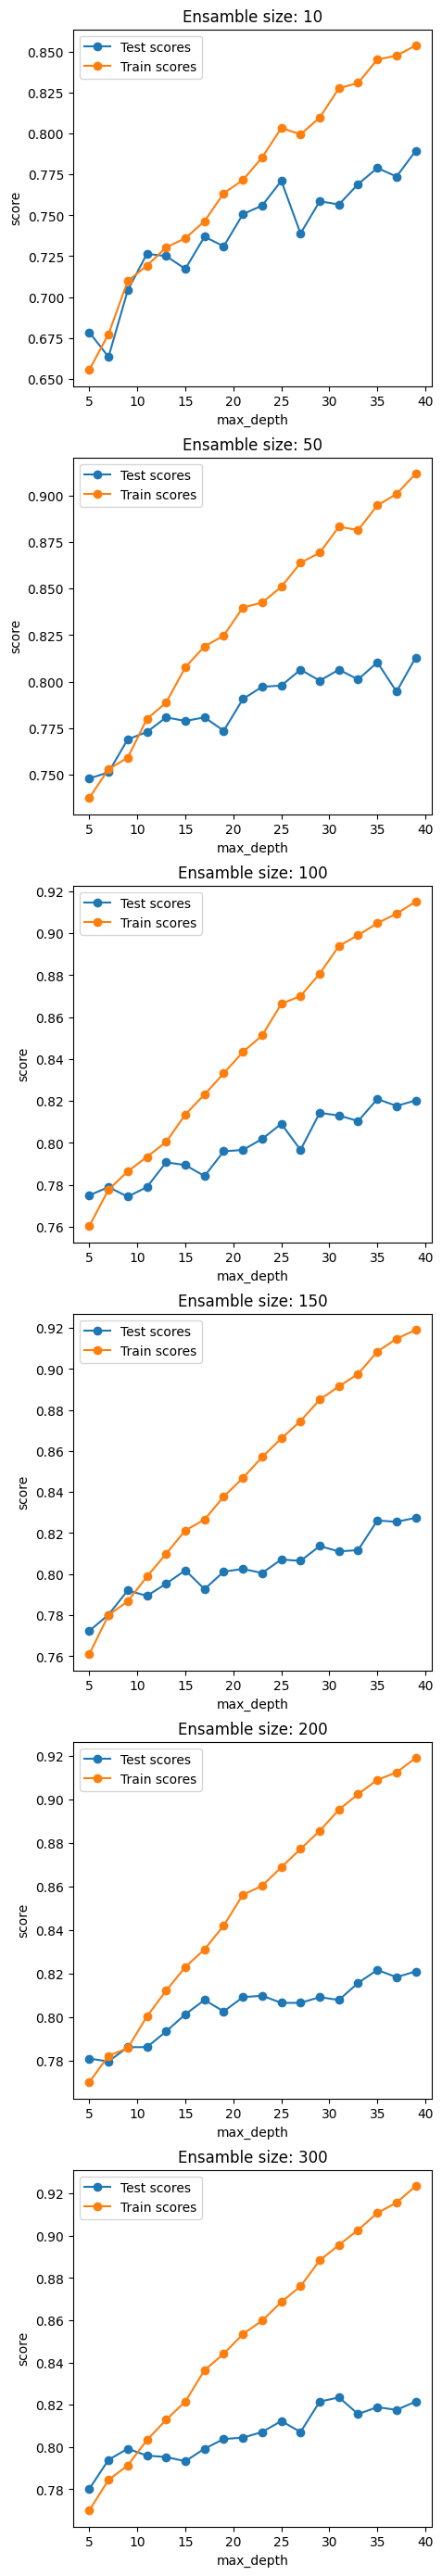

In [ ]:
# Plot random forest scores
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(ensamble_sizes), 1, figsize=(5, 35))

for i in range(0,len(ensamble_sizes)):
    axs[i].plot(max_depths, test_scores[ensamble_sizes[i]], '-o', label="Test scores")
    axs[i].plot(max_depths, train_scores[ensamble_sizes[i]], '-o', label="Train scores")
    axs[i].set_xlabel("max_depth")
    axs[i].set_ylabel("score")
    axs[i].legend()
    axs[i].set_title(f'Ensamble size: {ensamble_sizes[i]}')
    

In [165]:
# Multi layer perception (MLP) classifier
from sklearn.neural_network import MLPClassifier

# TD-IDF Vectorizer + MLP classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    MLPClassifier(hidden_layer_sizes=(5, ))
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + MLP classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + MLP classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))




/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


TF-IDF Vectorizer + MLP classifier test scores: Accuracy: 0.801, Recall: 0.798, F1: 0.8, Precision: 0.802


/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_pe

TF-IDF Vectorizer + MLP classifier training cross validation score:  [0.76373007 0.74279272 0.74971815 0.75467139 0.75467139]


/Users/jonasnordin/opt/anaconda3/envs/DAT341-Applied-Machine-Learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [158]:
# Perceptron classifier
from sklearn.linear_model import Perceptron

# TD-IDF vectorizer + Perceptron classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    Perceptron()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + Perceptron classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + Perceptron classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Count vectorizer + Perceptron classifier pipeline
pipeline = make_pipeline(
    CountVectorizer(),
    Perceptron()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Count Vectorizer + Perceptron classifier test scores", Ytest, pipeline.predict(Xtest))
print("Count Vectorizer + Perceprton classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

# Hash vectorizer + Perceptron classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    Perceptron()
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hash Vectorizer + Perceptron classifier test scores", Ytest, pipeline.predict(Xtest))
print("Hash Vectorizer + Perceprton classifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

TF-IDF Vectorizer + Perceptron classifier test scores: Accuracy: 0.791, Recall: 0.812, F1: 0.796, Precision: 0.78
TF-IDF Vectorizer + Perceptron classifier training cross validation score:  [0.77661459 0.76228056 0.77903044 0.76868557 0.77657861]
Count Vectorizer + Perceptron classifier test scores: Accuracy: 0.817, Recall: 0.778, F1: 0.81, Precision: 0.844
Count Vectorizer + Perceprton classifier training cross validation score:  [0.79223708 0.743598   0.75793203 0.76626933 0.77367912]
Hash Vectorizer + Perceptron classifier test scores: Accuracy: 0.808, Recall: 0.854, F1: 0.816, Precision: 0.782
Hash Vectorizer + Perceprton classifier training cross validation score:  [0.77129973 0.74875181 0.78047995 0.74403995 0.78543814]


In [181]:
# K neighbours classifier
from sklearn.neighbors import KNeighborsClassifier


# TD-IDF vectorizer + KNeighborsClassifier classifier pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    KNeighborsClassifier(n_neighbors=110, n_jobs=-1)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("TF-IDF Vectorizer + KNeighborsClassifier classifier test scores", Ytest, pipeline.predict(Xtest))
print("TF-IDF Vectorizer + KNeighborsClassifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))


# Count vectorizer + KNeighborsClassifier classifier pipeline
pipeline = make_pipeline(
    CountVectorizer(),
    KNeighborsClassifier(n_neighbors=110, n_jobs=-1)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Count Vectorizer + KNeighborsClassifier classifier test scores", Ytest, pipeline.predict(Xtest))
print("Count Vectorizer + KNeighborsClassifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

# Hash vectorizer + KNeighborsClassifier classifier pipeline
pipeline = make_pipeline(
    HashingVectorizer(),
    KNeighborsClassifier(n_neighbors=110, n_jobs=-1)
)
pipeline.fit(Xtrain, Ytrain)
print_scores("Hash Vectorizer + KNeighborsClassifier classifier test scores", Ytest, pipeline.predict(Xtest))
print("Hash Vectorizer + KNeighborsClassifier training cross validation score: ", cross_val_score(pipeline, Xtrain, Ytrain))

TF-IDF Vectorizer + KNeighborsClassifier classifier test scores: Accuracy: 0.836, Recall: 0.843, F1: 0.837, Precision: 0.832
TF-IDF Vectorizer + KNeighborsClassifier training cross validation score:  [0.79578032 0.77951361 0.78466742 0.78012242 0.78253866]
Count Vectorizer + KNeighborsClassifier classifier test scores: Accuracy: 0.699, Recall: 0.627, F1: 0.676, Precision: 0.732
Count Vectorizer + KNeighborsClassifier training cross validation score:  [0.65437268 0.67080045 0.68046384 0.63981959 0.6222616 ]
Hash Vectorizer + KNeighborsClassifier classifier test scores: Accuracy: 0.75, Recall: 0.857, F1: 0.774, Precision: 0.706
Hash Vectorizer + KNeighborsClassifier training cross validation score:  [0.68416814 0.69624738 0.70784345 0.67509665 0.69603737]


In [231]:
# Calculate consensus of the data

annotated_data = pd.read_table("data/a3_train_final.tsv", names=["annotation", "comment"])

def get_consensus_rate(anno):
    a = anno.split("/")
    c = Counter(a)
    return c.most_common(1)[0][1] / c.total()

annotated_data["consensus_rate"] = annotated_data.apply(lambda row: get_consensus_rate(row[0]), axis=1)

print(annotated_data['consensus_rate'].mean())

print(annotated_data[['annotation', 'consensus_rate']].head(20))



0.9255248834429249
   annotation  consensus_rate
0         1/1            1.00
1        0/-1            0.50
2         0/0            1.00
3        0/-1            0.50
4    1/1/1/-1            0.75
5        1/-1            0.50
6         1/1            1.00
7         0/0            1.00
8        1/-1            0.50
9         1/1            1.00
10        0/0            1.00
11       0/-1            0.50
12        0/0            1.00
13   1/0/-1/0            0.50
14        1/1            1.00
15       0/-1            0.50
16        0/0            1.00
17        0/0            1.00
18          0            1.00
19        0/0            1.00
